In [1]:
from utils import *
from environnement import Environnement
from policies import *
from tester import Tester
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
params = {
    'n_steps':500,
    "n_rep":3
}
env_params = {
    'experiment_length':1000, # Beaucoup de jours
    "n_users":10, #peu d'utilisateur
    "n_clusters":5, # peu de vélos
    'dim':5,
    "n_bikes_per_user":1, # Un seul vélo proposé à chaque fois
    "users_per_day":1,
    'bike_overlapping':False
}
env = Environnement(env_params,14)

In [3]:
tester = Tester([
    UCBPolicy({"list_length":1,"price":500,"n_bikes":5,"eps":0.5},3),
    DeepPolicyMemory({"list_length":1,"price":500,"n_bikes":5,"eps":0.5,"n_users":10,"embedding_size":5,"memory":200},3),
    EGreedyPolicy({"list_length":1,"price":500,"n_bikes":5,"eps":0.5},3),
    RandomPolicy({"list_length":1,"price":500},3),
    SmarterRandomPolicy({"list_length":1,"price":500},3),
    Thomson_SamplingPolicy({"list_length":1,"price":500,"n_bikes":5,"n_users":10},3),
    
    
],env,params)

In [4]:
tester.run()

  0%|          | 0/500 [00:00<?, ?it/s]

Testing policy |UCBPolicy_500| rep 1/3


  1%|          | 6/500 [00:00<00:08, 55.05it/s]

Testing policy |UCBPolicy_500| rep 2/3


  1%|          | 5/500 [00:00<00:10, 49.08it/s]

Testing policy |UCBPolicy_500| rep 3/3


  0%|          | 0/500 [00:00<?, ?it/s]

Testing policy |DeepPolicyMemory_500_200| rep 1/3


  1%|          | 5/500 [00:00<00:10, 47.07it/s]

Testing policy |DeepPolicyMemory_500_200| rep 2/3


  0%|          | 0/500 [00:00<?, ?it/s]

Testing policy |DeepPolicyMemory_500_200| rep 3/3


  1%|          | 6/500 [00:00<00:08, 55.45it/s]

Testing policy |EGreedyPolicy_500| rep 1/3


  1%|          | 5/500 [00:00<00:10, 49.02it/s]

Testing policy |EGreedyPolicy_500| rep 2/3


  1%|          | 5/500 [00:00<00:10, 47.61it/s]

Testing policy |EGreedyPolicy_500| rep 3/3


  1%|          | 6/500 [00:00<00:08, 59.86it/s]

Testing policy |RandomPolicy_500| rep 1/3


  1%|          | 6/500 [00:00<00:08, 57.18it/s]

Testing policy |RandomPolicy_500| rep 2/3


  1%|          | 6/500 [00:00<00:09, 54.42it/s]

Testing policy |RandomPolicy_500| rep 3/3


  1%|▏         | 7/500 [00:00<00:07, 64.69it/s]

Testing policy |SmarterRandomPolicy_500| rep 1/3


  1%|          | 6/500 [00:00<00:08, 55.80it/s]

Testing policy |SmarterRandomPolicy_500| rep 2/3


  1%|          | 5/500 [00:00<00:11, 43.10it/s]

Testing policy |SmarterRandomPolicy_500| rep 3/3


  1%|          | 6/500 [00:00<00:08, 58.21it/s]

Testing policy |Thomson_SamplingPolicy_500| rep 1/3


  1%|          | 5/500 [00:00<00:09, 49.95it/s]

Testing policy |Thomson_SamplingPolicy_500| rep 2/3


  1%|          | 6/500 [00:00<00:09, 51.66it/s]

Testing policy |Thomson_SamplingPolicy_500| rep 3/3


100%|██████████| 500/500 [00:11<00:00, 42.48it/s]


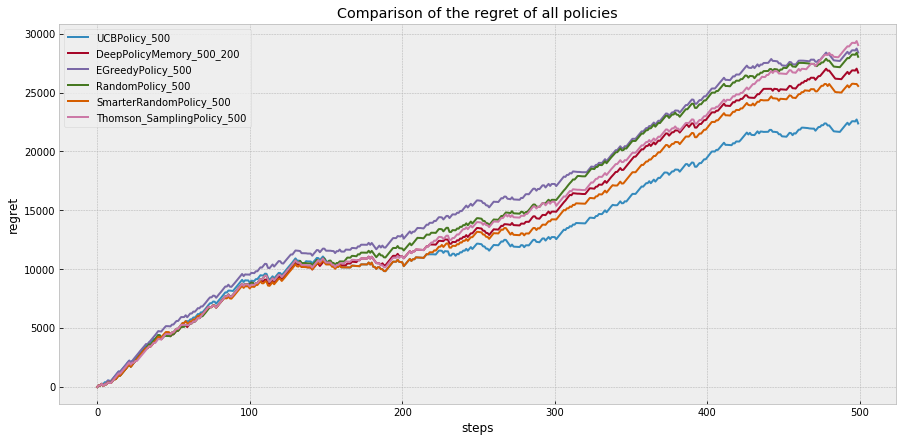

In [5]:
tester.plotAllPoliciesCompared()

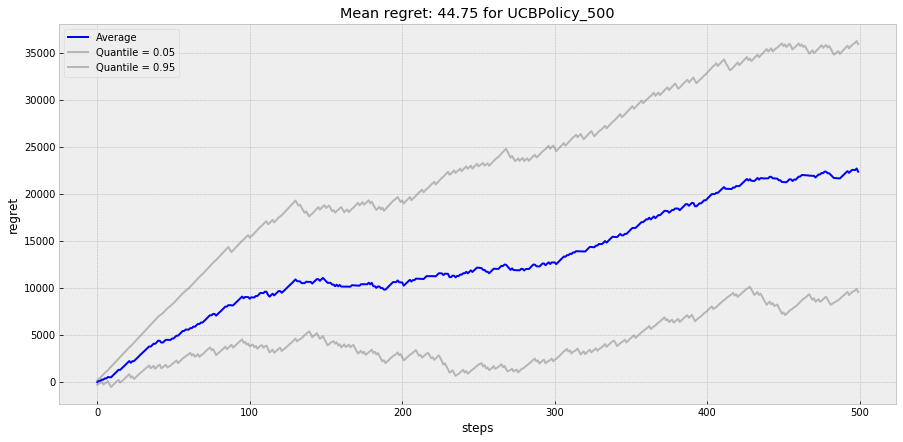

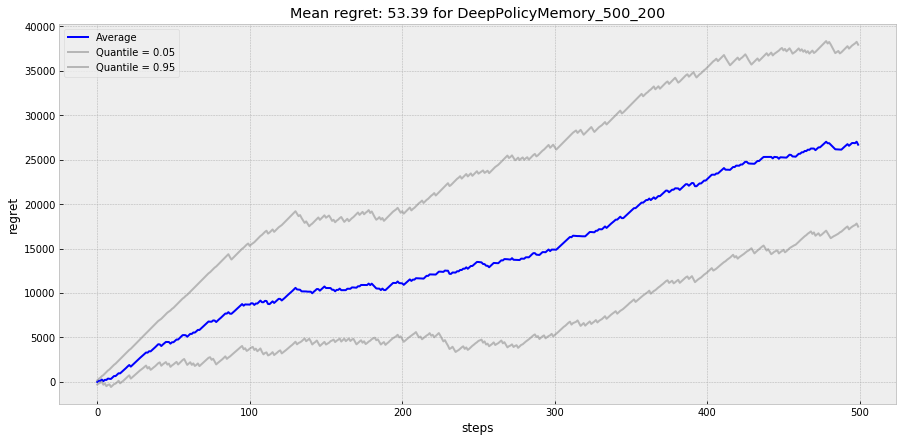

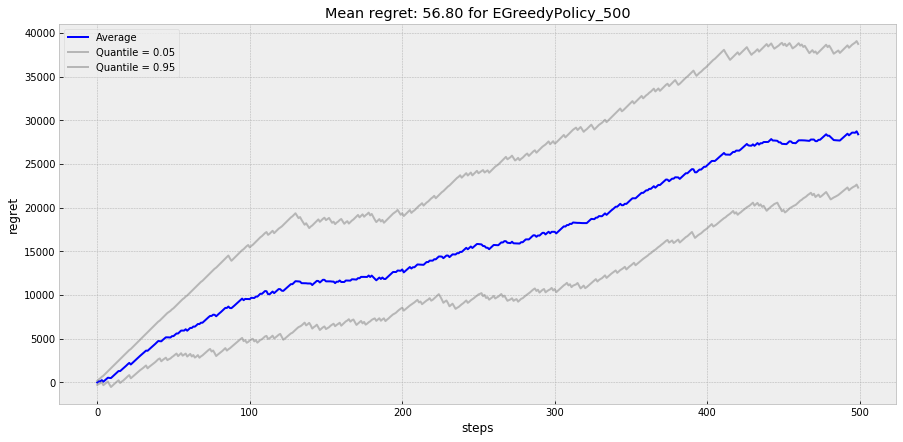

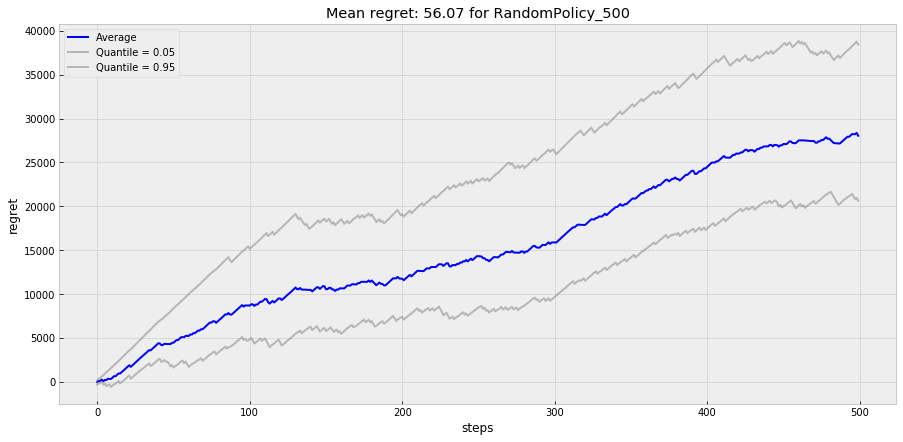

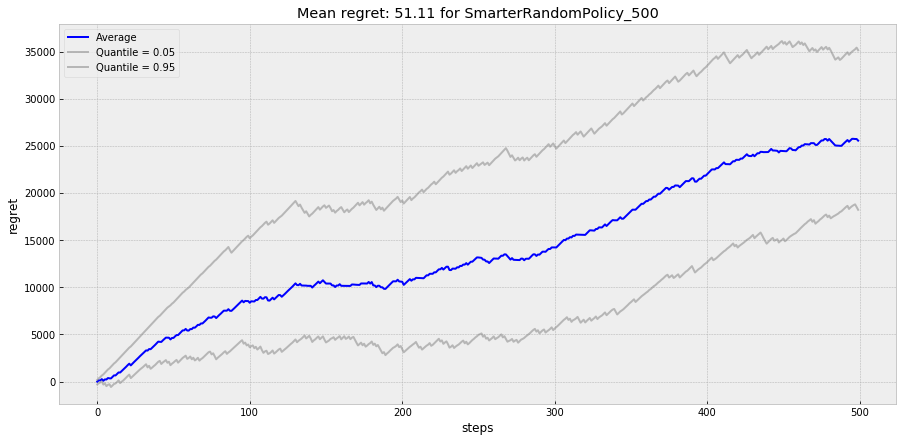

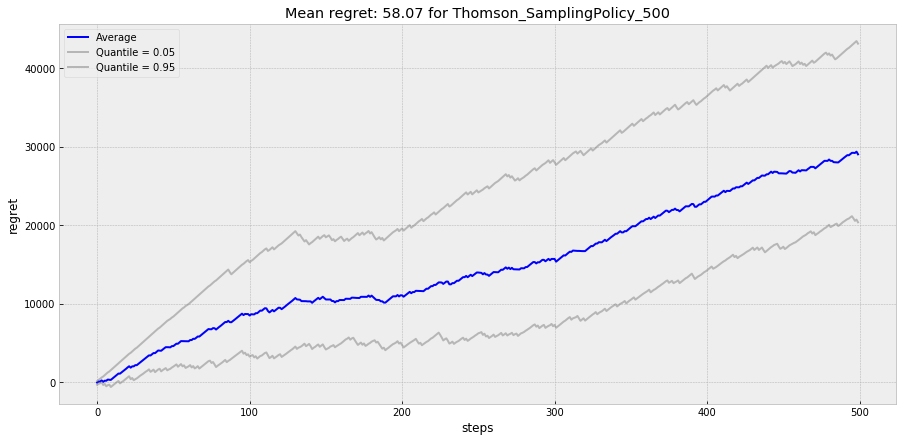

In [6]:
tester.plotAllPoliciesQuantiles()